![](../img/330-banner.png)

# Lecture 18: Multi-class classification and introduction to computer vision 

UBC 2025-26

## Imports and LO

### Imports

In [1]:
import copy
import glob
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.path.abspath(".."), "code"))

from plotting_functions import *
from deep_learning_code import *
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

DATA_DIR = os.path.join(os.path.abspath(".."), "data/")

### Learning objectives

- Describe what multiclass classification is and how it differs from binary classification
  
- Explain how logisitic regression prediction is extended to the multiclass setting (multinominal/softmax) and roughly count its parameters
- Explain the basics of neural networks and how they build upon linear models.
- Explain at a high level what makes a model "deep"
- Describe the role of neural networks in machine learning, including their strengths and limitations.
- Explain the intuition behind convolutional neural networks: what filters do, how they slide over an image and why this helps with images 
- Explain why the methods we've learned previously would not be effective on image data.
- Define transfer learning and explain why pre-trained models are useful in vision and NLP. 
- Apply pre-trained neural networks to classification and regression problems.
- Utilize pre-trained networks as feature extractors and train simple classifier (e.g., logistic regression) on top

## ❓❓ Questions for you

### iClicker Exercise

**Select all of the following statements which are TRUE.**

- (A) It's possible to use word2vec embedding representations for text classification instead of bag-of-words representation. 
- (B) The topic model approach we used in the last lecture, Latent Dirichlet Allocation (LDA), is an unsupervised approach. 
- (C) In an LDA topic model, the same word can be associated with two different topics with high probability.
- (D) In an LDA topic model, a document is a mixture of multiple topics. 
- (E) If I train a topic model on a large collection of news articles with K = 10, I would get 10 topic labels (e.g., sports, culture, politics, finance) as output. 

<br><br>

## Multi-class classification 

- So far, we’ve focused on binary classification (two classes).
- Can we use these classifiers when there are more than two classes? 
    - ["ImageNet" computer vision competition](http://www.image-net.org/challenges/LSVRC/), for example, has 1000 classes
- The goal of multi-class classification is to assign each example to exactly one of $K$ possible classes.
- Can we use decision trees or KNNs for multi-class classification?
- What about logistic regression?

- Some models naturally extend to multiclass classification. 
- If they don't a common technique is to reduce multiclass classication into several instances of binary classification problems. 
- Two kind of "hacky" ways to reduce multi-class classification into binary classification:  
    - the one-vs.-rest approach
    - the one-vs.-one approach
- Check out [AppendixD](AppendixD.html) for more details. 

Let's look at a multiclass classification with logistic regression. 

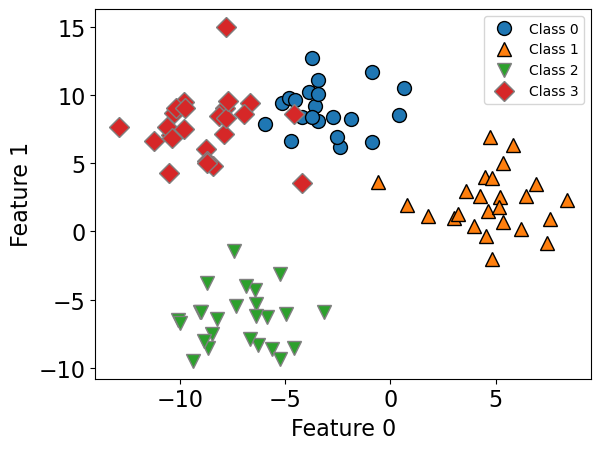

In [2]:
import mglearn
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, n_samples=120, cluster_std=2.0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(["Class 0", "Class 1", "Class 2", "Class 3"], fontsize=10);

In [3]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [4]:
lr.score(X_train, y_train)

0.96875

In [5]:
lr.score(X_test, y_test)

0.9583333333333334

Logisitic regression learns a coefficient associated with each feature and each class. 

In [6]:
lr.coef_

array([[ 0.29324459,  0.7588186 ],
       [ 1.17054987, -0.31908384],
       [-0.3298721 , -0.84698489],
       [-1.13392236,  0.40725012]])

For each class there is an intercept.  

In [7]:
lr.intercept_

array([-0.64417243,  5.10584062,  1.09706504, -5.55873323])

### Predictions

- Predictions are made by
    - getting raw scores for each class
    - applying **softmax** instead of **sigmoid** to get probability distribution over a number of classes
    - picking the class with the highest prediction probability

### Sigmoid vs. Softmax 
- For binary classification, we used the sigmoid function, which "squashes" the raw model output from any number to the range $[0,1]$ using the following formula, where $x$ is the raw model output. 
$$\frac{1}{1+e^{-x}}$$
- For multiclass classification, instead of sigmoid, we use softmax, which normalizes a set of raw scores into probabilities. 

$$\sigma(\vec{z})_i=\frac{e^{z_i}}{\sum_{j=1}^{K}e^{z_j}}$$

- It basically makes sure all the outputs are probabilities between 0 and 1, and that they all sum to 1.

We can examine class probabilities by calling `predict_proba` on an example. 

In [8]:
lr.predict_proba(X_test)[0]

array([4.10793260e-03, 2.31298589e-08, 5.83848726e-06, 9.95886206e-01])

In [9]:
lr.classes_

array([0, 1, 2, 3])

In [10]:
# The prediction here is class 3 because it has the highest predict proba score of 0.995
lr.predict(X_test)[0]

np.int64(3)

<br><br><br><br>

## Introduction to neural networks
- Very popular these days under the name **deep learning**. 
- Remember this picture we saw at the beginning of the course? Deep learning is a subset of machine learning.

![](../img/ai-ml-dl.png)

- Neural networks apply a sequence of transformations to the input data.

- You can think of them as a generalization of linear models, where multiple layers of transformations are applied in succession.

- Here is graphical representation of a logistic regression model. 
    - We have 4 features: `x[0], x[1], x[2], x[3]`

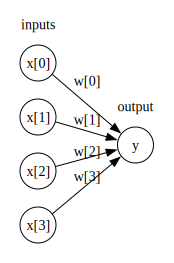

In [11]:
import mglearn

mglearn.plots.plot_logistic_regression_graph()

- Below we are adding one "layer" of transformations in between features and the target. 
- We are repeating the the process of computing the weighted sum multiple times.  
- The **hidden units** (e.g., h[1], h[2], ...) represent the intermediate processing steps. 

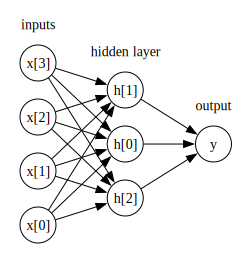

In [12]:
mglearn.plots.plot_single_hidden_layer_graph()

- Now we are adding one more layer of transformations. 

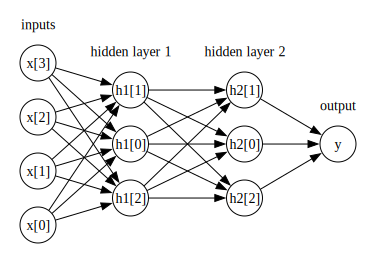

In [13]:
mglearn.plots.plot_two_hidden_layer_graph()

- At a very high level you can also think of them as `Pipelines` in `sklearn`. 
- A neural network is a model that's sort of like its own pipeline
  - It involves a series of transformations ("layers") internally. 
  - The output is the prediction.

![](../img/pipeline.png)

<!-- <img src='./img/pipeline.png' width="800"> -->
    
[Source](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#18)

- Important question: how many features before/after transformation.
  - e.g. scaling doesn't change the number of features
  - OHE increases the number of features
- With a neural net, you specify the number of features after each transformation.
  - In the above, it goes from 4 to 3 to 3 to 1.

- To make them really powerful compared to the linear models, we apply a non-linear function to the weighted sum for each hidden node. 

### Neural networks example and terminology

- Neural network = neural net
- Deep learning ~ using neural networks
- This type of neural network is also referred to as a **feed-forward neural network**  

![](../img/nn-10.png)

### (Optional) How does training work in neural networks? (High-Level)

Training a neural network has **two main steps:**

- **Forward pass:**  
  Feed the input through the network to calculate the predicted output using the current parameter values (weights).

- **Backward pass:**  
  - Measure how far the predicted output is from the actual target (this is the **loss**).
  - Calculate how to adjust each parameter to improve future predictions (**gradients**).
  - Update the parameters using these gradients — this helps the model improve.

- Summary
  - **Input $\rightarrow$ Forward Pass $\rightarrow$ Loss $\rightarrow$ Backward Pass $\rightarrow$ Parameter Update $\rightarrow$ Repeat**
  - The model repeats this process many times, gradually improving its predictions.


### Why neural networks?

- They can learn very complex functions.
  - The fundamental tradeoff is primarily controlled by the **number of layers** and **layer sizes**.
  - More layers / bigger layers --> more complex model.
  - You can generally get a model that will not underfit.

- The work really well for structured data:
  - 1D sequence, e.g. timeseries, language
  - 2D image
  - 3D image or video
- They've had some incredible successes in the last 10 years.
- Transfer learning (coming later today) is really useful.  

### Why not neural networks?

- Often they require a lot of data.
- They require a lot of compute time, and, to be faster, specialized hardware called [GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit).
- They have huge numbers of hyperparameters are a huge pain to tune.
  - Think of each layer having hyperparameters, plus some overall hyperparameters.
  - Being slow compounds this problem.
- They are not interpretable.

- When you call `fit`, you are not guaranteed to get the optimal.
  - There are now a bunch of hyperparameters specific to `fit`, rather than the model.
  - You never really know if `fit` was successful or not.
  - You never really know if you should have run `fit` for longer.
- I don't recommend training them on your own without further training
  - Take CPSC 340 and other courses if you're interested.
  - I'll show you some ways to use neural networks without calling `fit`.

### Deep learning software

- scikit-learn has [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) and [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) but they aren't very flexible.
  - In general you'll want to leave the scikit-learn ecosystem when using neural networks.
  - Fun fact: these classes were contributed to scikit-learn by a UBC graduate student.
- There's been a lot of deep learning software out there.

- The current big players are:

1. [PyTorch](http://pytorch.org)
2. [TensorFlow](https://www.tensorflow.org)

- Both are heavily used in industry.
- If interested, see [comparison of deep learning software](https://en.wikipedia.org/wiki/Comparison_of_deep_learning_software).

## Break (5 min)

![](../img/eva-coffee.png)

<br><br><br><br>

## Introduction to computer vision

- [Computer vision](https://en.wikipedia.org/wiki/Computer_vision) refers to understanding images/videos, usually using ML/AI. 
- Computer vision has many tasks of interest:
  - image classification: is this a cat or a dog?
  - object localization: where is the cat in this image?
  - object detection: What are the various objects in the image? 
  - instance segmentation: What are the shapes of these various objects in the image? 
  - and much more...

![](../img/vision-apps.jpeg)

Source: https://learning.oreilly.com/library/view/python-advanced-guide/9781789957211/

- In the last decade this field has been dominated by deep learning. 
- We will explore **image classification**.

### Convolutional Neural Networks (CNNs) (high level)

- Neural networks come in different shapes depending on the type of data and the task.
- CNNs are commonly used in **image classification, object detection, and medical imaging.**
- What's the problem if we use the above feedforward architecture to learn patterns from images? 

![](../img/cnn-1.png)

- Fully connected networks are not well-suited for images because:
  - **Too many parameters:** Every pixel connects to every neuron, causing the number of parameters to explode.
    
  - **No notion of spatial structure:** The model treats pixels independently and ignores the 2D arrangement of the image.
    
  - **Lack of translation invariance:** A pattern appearing in a different part of the image looks completely different to the model, so it must relearn the same pattern in multiple positions.


**Filters** 

- **Convolutional Neural Networks (CNNs)** address these issues by using filters that *slide* over the input to detect local patterns.

- Each filter looks for a specific kind of pattern—similar to how a metal detector only reacts when it finds metal.

- In the example below, the filter is a 2×2 grid that slides over the image:
  - When the region under the filter matches the pattern the filter is looking for, it produces a large activation.  
  - Otherwise, it produces a small activation.
 

![](../img/cnn-4.png)

![](../img/cnn-5.gif)

- Play around with filters: https://setosa.io/ev/image-kernels/

**(Optional) CNNs big picture**

![](../img/cnn_big_picture.png)


Let's explore these ideas using a subset of [Kaggle's Animal Faces dataset](https://www.kaggle.com/datasets/andrewmvd/animal-faces). 

### Transfer learning

- In practice, very few people train an entire CNN from scratch because it requires a large dataset, powerful computers, and a huge amount of human effort to train the model. 
- Instead, a common practice is to download a pre-trained model and fine tune it for your task.   
- This is called **transfer learning**. 
- Transfer learning is one of the most common techniques used in the context of computer vision and natural language processing.
    - In the last lecture we used pre-trained embeddings to create text representations.     

- There are many deep learning architectures out there that have been very successful across a wide range of problem, e.g.: AlexNet, VGG, ResNet, Inception, MobileNet, etc.
- Many of these are trained on famous datasets such as ImageNet (which contains 1.2 million labelled images with 1000 categories)

**ImageNet**

- [ImageNet](http://www.image-net.org/) is an image dataset that became a very popular benchmark in the field ~10 years ago. 
    - There are 14 million images and 1000 classes.
    - Here are some example classes. 
    - [Wikipedia article](https://en.wikipedia.org/wiki/ImageNet) on ImageNet


In [14]:
with open(DATA_DIR + "imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]
classes[100:110]

['black swan, Cygnus atratus',
 'tusker',
 'echidna, spiny anteater, anteater',
 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 'wallaby, brush kangaroo',
 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 'wombat',
 'jellyfish',
 'sea anemone, anemone',
 'brain coral']

- The idea of transfer learning is instead of developing a machine learning model from scratch, you use these available pre-trained models for your tasks either directly or by fine tuning them. 
- There are three common ways to use transfer learning in computer vision 
    1. Using pre-trained models out-of-the-box 
    2. Using pre-trained models as feature extractor and training your own model with these features
    2. Starting with weights of pre-trained models and fine-tuning the weights for your task. 
- We will explore the first two approaches.     

<br><br>

### Using pre-trained models out-of-the-box 

- Remember this example I showed you in the intro video (our very first lecture)?
- We used a pre-trained model vgg16 which is trained on the ImageNet data. 
- We preprocess the given image. 
- We get prediction from this pre-trained model on a given image along with prediction probabilities.  
- For a given image, this model will spit out one of the 1000 classes from ImageNet. 

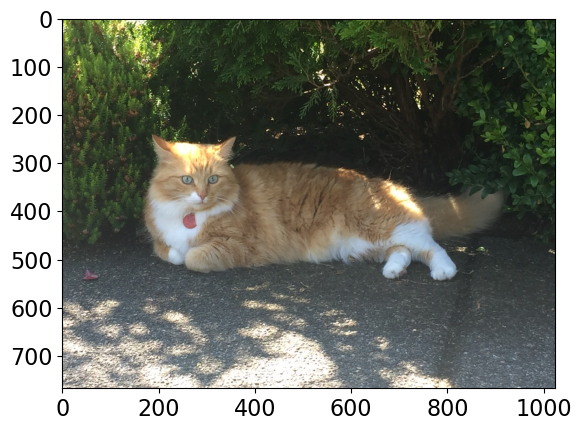

                         Class  Probability score
                     tiger cat              0.353
              tabby, tabby cat              0.207
               lynx, catamount              0.050
Pembroke, Pembroke Welsh corgi              0.046
--------------------------------------------------------------


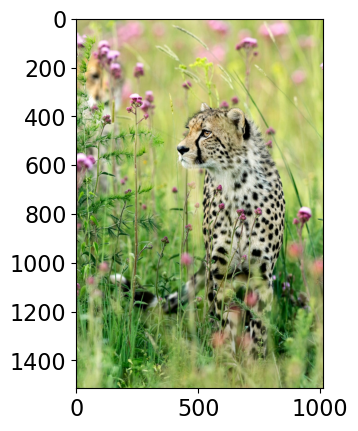

                                     Class  Probability score
         cheetah, chetah, Acinonyx jubatus              0.983
                  leopard, Panthera pardus              0.012
jaguar, panther, Panthera onca, Felis onca              0.004
       snow leopard, ounce, Panthera uncia              0.001
--------------------------------------------------------------


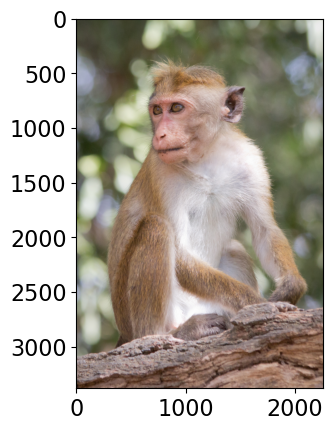

                                   Class  Probability score
                                 macaque              0.714
patas, hussar monkey, Erythrocebus patas              0.122
      proboscis monkey, Nasalis larvatus              0.098
                   guenon, guenon monkey              0.017
--------------------------------------------------------------


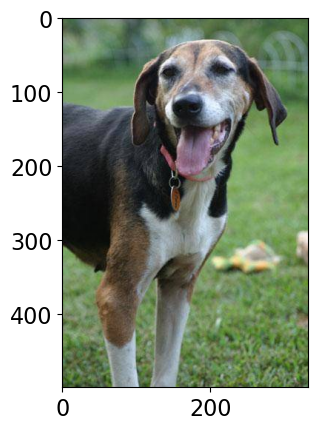

                        Class  Probability score
Walker hound, Walker foxhound              0.580
             English foxhound              0.091
                  EntleBucher              0.080
                       beagle              0.065
--------------------------------------------------------------


In [15]:
# Predict labels with associated probabilities for unseen images
images = glob.glob(DATA_DIR + "test_images/*.*")
for image in images:
    img = Image.open(image)
    img.load()
    plt.imshow(img)
    plt.show()
    df = classify_image(img)
    print(df.to_string(index=False))
    print("--------------------------------------------------------------")

<br><br><br><br>

- We got these predictions without "doing the ML ourselves".

- We are using **pre-trained** `vgg16` model which is available in `torchvision`.
- `torchvision` has many such pre-trained models available that have been very successful across a wide range of tasks: AlexNet, VGG, ResNet, Inception, MobileNet, etc.
- Many of these models have been pre-trained on famous datasets like **ImageNet**. 
- So if we use them out-of-the-box, they will give us one of the ImageNet classes as classification. 

![](../img/cnn-ex.png)

Source: https://cezannec.github.io/Convolutional_Neural_Networks/

Let's see what labels this pre-trained model gives us for some images which are very different from the training set. 

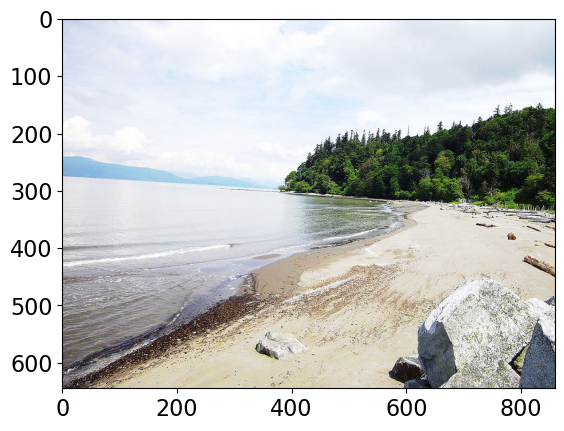

                                                   Class  Probability score
                                       sandbar, sand bar              0.421
                    seashore, coast, seacoast, sea-coast              0.157
breakwater, groin, groyne, mole, bulwark, seawall, jetty              0.071
                                     lakeside, lakeshore              0.036
--------------------------------------------------------------


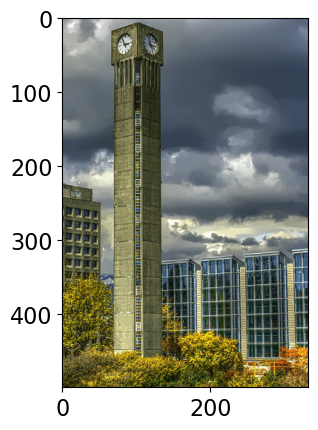

              Class  Probability score
            obelisk              0.104
               pole              0.077
bell cote, bell cot              0.057
       sliding door              0.045
--------------------------------------------------------------


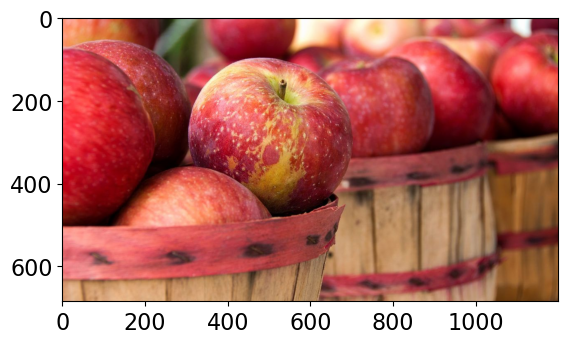

                                      Class  Probability score
                                        fig              0.637
                                pomegranate              0.193
grocery store, grocery, food market, market              0.041
                                      crate              0.023
--------------------------------------------------------------


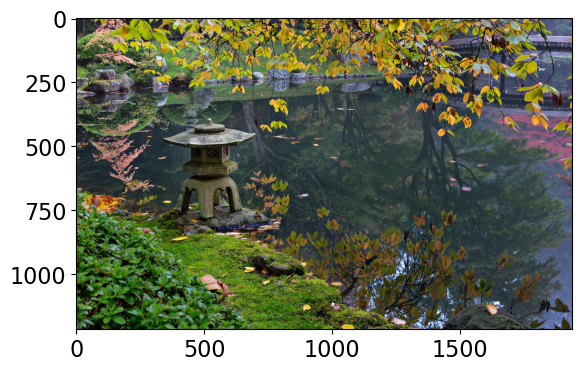

     Class  Probability score
    castle              0.056
     altar              0.056
  fountain              0.051
park bench              0.049
--------------------------------------------------------------


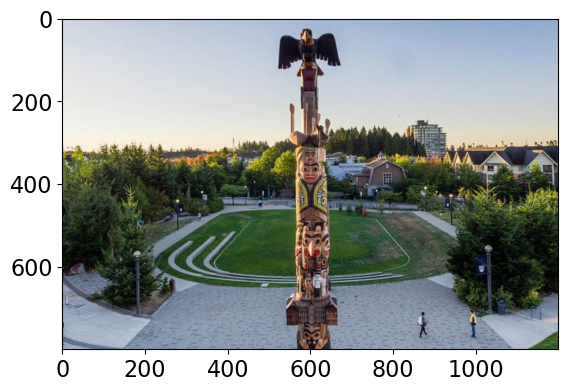

                      Class  Probability score
                 totem pole              0.987
                       pole              0.011
                    sundial              0.000
pedestal, plinth, footstall              0.000
--------------------------------------------------------------


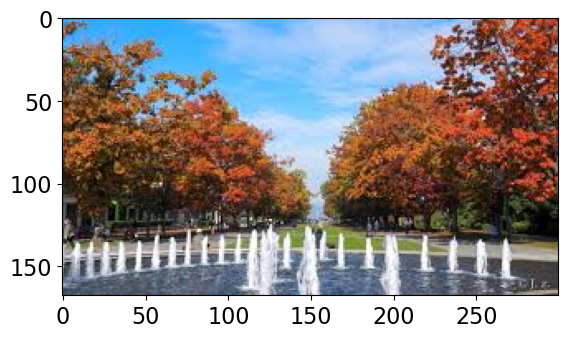

                                                    Class  Probability score
                                      lakeside, lakeshore              0.568
worm fence, snake fence, snake-rail fence, Virginia fence              0.180
                                                boathouse              0.101
                           mobile home, manufactured home              0.017
--------------------------------------------------------------


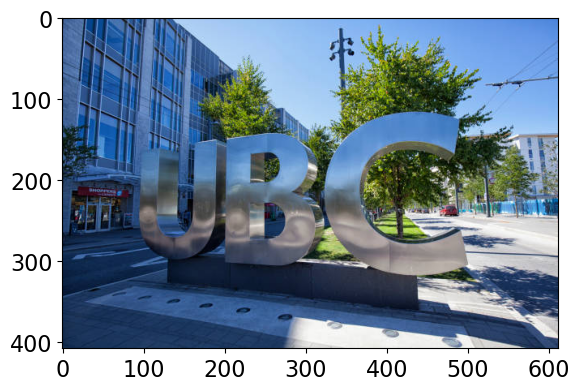

                                               Class  Probability score
                                         toilet seat              0.171
                                          safety pin              0.060
bannister, banister, balustrade, balusters, handrail              0.039
                                              bubble              0.035
--------------------------------------------------------------


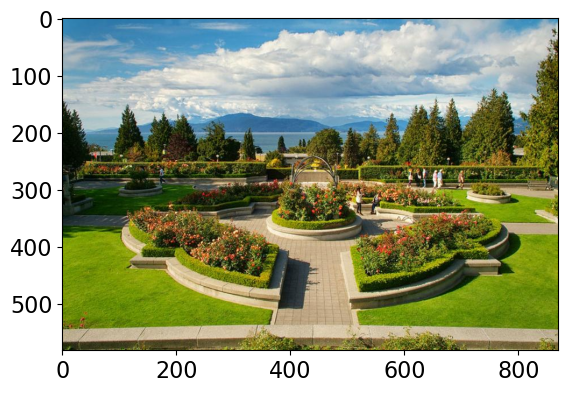

              Class  Probability score
     patio, terrace              0.213
           fountain              0.164
lakeside, lakeshore              0.097
            sundial              0.088
--------------------------------------------------------------


In [16]:
# Predict labels with associated probabilities for unseen images
images = glob.glob(DATA_DIR + "UBC_img/*.*")
for image in images:
    img = Image.open(image)
    img.load()
    plt.imshow(img)
    plt.show()
    df = classify_image(img)
    print(df.to_string(index=False))
    print("--------------------------------------------------------------")

- It's not doing very well here because ImageNet don't have proper classes for these images. 
- Here we are using pre-trained models out-of-the-box. 
- Can we use pre-trained models for our own classification problem with our classes? 
- Yes!! 

<br><br>

## Using pre-trained models as feature extractor

- Let's use pre-trained models to extract features.
- We will pass our specific data through a pre-trained network to get a feature vector for each example in the data. 
- The feature vector is usually extracted from the last layer, before the classification layer from the pre-trained network. 
- You can think of each layer as a transformer applying some transformations on the input received. 

![](../img/cnn-ex.png)

Source: https://cezannec.github.io/Convolutional_Neural_Networks/

- Once we extract these feature vectors for all images in our training data, we can train a machine learning classifier such as logistic regression or random forest. 
- This classifier will be trained on our classes using feature representations extracted from the pre-trained models.  
- Let's try this out. 
- It's better to train such models with GPU. Since our dataset is quite small, we won't have problems running it on a CPU. 

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device.type}")

Using device: cpu


### Dataset

- Let's try it out on a tiny subset of [Food-101 dataset](https://www.kaggle.com/datasets/kmader/food41?select=food_c101_n10099_r32x32x1.h5)
- Usually structured data such as this one doesn't come in CSV files. 
- Also, if you are working on image datasets in the real world, they are going to be huge datasets and you do not want to load the full dataset at once in the memory. 
- So usually you work on small batches. 
- You are not expected to understand all the code to read this dataset. But it's available here for your reference: `../code/dee_learning_code.py` for your reference. 

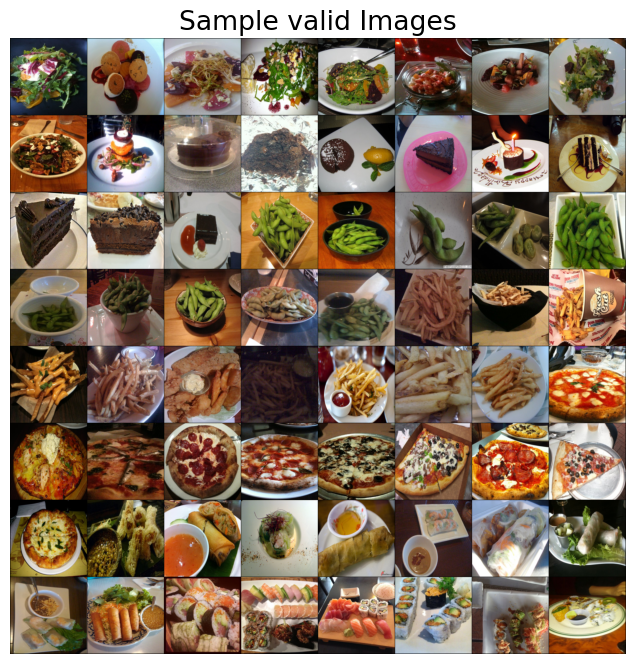

In [18]:
data_dir = DATA_DIR + 'food-transfer-learning'
image_datasets, dataloaders = read_data(data_dir)
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "valid"]}
class_names = image_datasets["train"].classes
inputs, classes = next(iter(dataloaders["valid"]))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample valid Images")
plt.imshow(np.transpose(utils.make_grid(inputs, padding=1, normalize=True),(1, 2, 0)));

In [19]:
print(f"Classes: {image_datasets['train'].classes}")
print(
    f"Class count: {image_datasets['train'].targets.count(0)}, {image_datasets['train'].targets.count(1)}, {image_datasets['train'].targets.count(2)}, {image_datasets['train'].targets.count(3)}, {image_datasets['train'].targets.count(4)}, {image_datasets['train'].targets.count(5)}, {image_datasets['train'].targets.count(6)}"
)
print(f"Samples:", len(image_datasets["train"]))

Classes: ['beet_salad', 'chocolate_cake', 'edamame', 'french_fries', 'pizza', 'spring_rolls', 'sushi']
Class count: 40, 38, 40, 40, 43, 41, 41
Samples: 283


- Now for each image in our dataset, we'll extract a feature vector from a pre-trained model called densenet121, which is trained on the ImageNet dataset.  

In [20]:
densenet = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
densenet.classifier = nn.Identity()  # remove that last "classification" layer
Z_train, y_train, Z_valid, y_valid = get_features(
    densenet, dataloaders["train"], dataloaders["valid"]
) # get_features is defined in ../code/deep_learning_code.py

Now we have extracted feature vectors for all examples. What's the shape of these features?

In [21]:
Z_train.shape

torch.Size([283, 1024])

The size of each feature vector is 1024 because the size of the last layer in densenet architecture is 1024.  

![](../img/densenet-architecture.png)

Source: https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a

Let's examine the feature vectors. 

In [22]:
pd.DataFrame(Z_train).head()

0         1         2         3         4         5         6     \
0  0.000628  0.001867  0.005263  0.000643  0.142653  0.544123  0.000459   
1  0.000108  0.001419  0.003320  0.000497  0.100592  0.031339  0.000039   
2  0.000350  0.006774  0.001326  0.000486  0.140210  0.257725  0.000773   
3  0.000423  0.005459  0.001522  0.000987  0.103520  1.944745  0.000781   
4  0.000289  0.001180  0.002293  0.001370  0.036232  0.290215  0.000142   

       7         8         9     ...      1014      1015      1016      1017  \
0  0.004617  0.515677  0.000261  ...  0.409525  1.786506  0.286545  0.811877   
1  0.003024  0.529213  0.000396  ...  0.014607  0.006724  0.440415  0.834180   
2  0.004360  0.162747  0.000161  ...  2.170512  0.576434  0.673951  1.197432   
3  0.004451  0.091491  0.000342  ...  1.202736  2.475188  1.089156  0.033112   
4  0.004044  0.559906  0.000636  ...  0.660837  0.000000  2.927826  0.949734   

       1018      1019      1020      1021      1022      1023  
0  0.481698  0.179061  1.025997  2.119834  2.038498  0.832221  
1  0.820326  1.111771  0.390103  1.340169  0.575759  0.728584  
2  1.226748  0.869713  0.113452  1.695449  0.203399  0.000000  
3  0.153164  1.799476  0.530470  1.092396  0.120929  4.028651  
4  0.440602  0.031607  0.000000  0.993694  0.131640  0.731354  

[5 rows x 1024 columns]

- The features are hard to interpret but they have some important information about the images which can be useful for classification.  
- Let's try out logistic regression on these extracted features. 

In [23]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))
pipe_lr.fit(Z_train, y_train)
pipe_lr.score(Z_train, y_train)

1.0

In [24]:
pipe_lr.score(Z_valid, y_valid)

0.8507462686567164

- This is great accuracy for so little data (we only have 283 examples) and little effort of all different types of food!!!
- With logistic regression and flattened representation of images we would get much worse accuracy.

<br><br>

## Object detection

- Another useful task and tool to know is object detection using YOLO model. 
- Let's identify objects in a sample image using a pretrained model called YOLO8. 
- List the objects present in this image.

**Object detection using [YOLO](https://docs.ultralytics.com/)**

Let's try this out using a pre-trained model. We'll use the `ultralytics` package for this, which you'll have to install in the course environment. 

```pip install ultralytics```


image 1/1 /Users/kvarada/CS/2025-26/330/cpsc330-2025W1/lectures/data/yolo_test/3356700488_183566145b.jpg: 512x640 4 persons, 2 cars, 1 stop sign, 64.2ms
Speed: 3.1ms preprocess, 64.2ms inference, 8.9ms postprocess per image at shape (1, 3, 512, 640)


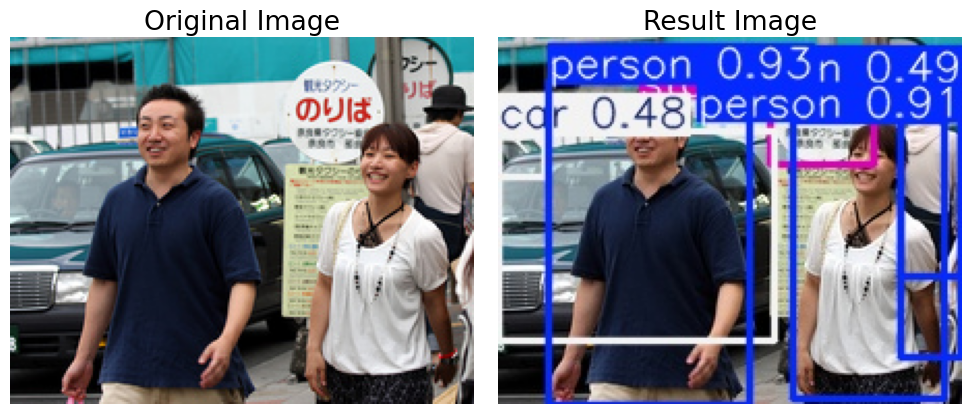

In [25]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # pretrained YOLOv8n model

yolo_input = DATA_DIR + "yolo_test/3356700488_183566145b.jpg"
yolo_result = DATA_DIR + "yolo_result.jpg"

# Run batched inference on a list of images
result = model(yolo_input)  # return a list of Results objects
result[0].save(filename=yolo_result)

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load the images
input_img = mpimg.imread(yolo_input)
result_img = mpimg.imread(yolo_result)

# Create a figure to display the images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axes[0].imshow(input_img)
axes[0].axis("off")  # Hide the axes
axes[0].set_title("Original Image")

# Display the second image
axes[1].imshow(result_img)
axes[1].axis("off")  # Hide the axes
axes[1].set_title("Result Image")

# Show the images
plt.tight_layout()
plt.show()

<br><br><br><br>

## Summary 

**Multi-class classification**
- Multi-class classification refers to classification with >2 classes.
  - Most sklearn classifiers work out of the box.
  - With `LogisticRegression` the situation with the coefficients is a bit different, we get 1 coefficient per feature per class.

**Neural networks**
- Neural networks are a flexible class of models.
  - They can be challenging to train and often require significant computational resources.; a lot more on that in CPSC 340.
  - They generally require leaving the sklearn ecosystem to tensorflow or pytorch.
  - They are particular powerful for structured input like images, videos, audio, etc.
- The good news is we can use pre-trained neural networks.
  - This saves us a huge amount of time/cost/effort/resources.
  - We can use these pre-trained networks directly or use them as feature transformers.

**Random cool stuff**

- Check out [3Blue1Brown series on Deep Learning](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi).
- [A nice video](https://www.youtube.com/watch?v=oGvHtpJMO3M) which gives a high-level introduction to computer vision.
- Style transfer: given a "content image" and a "style image", create a new image with the content of one and the style of the other.
  - Here is the [original paper from 2015](https://arxiv.org/pdf/1508.06576.pdf), see Figure 2.
  - Here are more in [this 2016 paper](https://arxiv.org/pdf/1601.04589.pdf); see, e.g. Figures 1 and 7.
  - This has been done for video as well; see [this video from 2016](https://www.youtube.com/watch?v=Khuj4ASldmU).
- [Image captioning](https://cs.stanford.edu/people/karpathy/sfmltalk.pdf): Transfer learning with NLP and vision 
- Colourization: see [this 2016 project](http://iizuka.cs.tsukuba.ac.jp/projects/colorization/en/).
- Inceptionism: let the neural network "make things up"
  - [2015 article](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
  - "Deep dream" [video from 2015](https://www.youtube.com/watch?v=dbQh1I_uvjo).
